In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

This may not be correct, but is what I'm using for now:
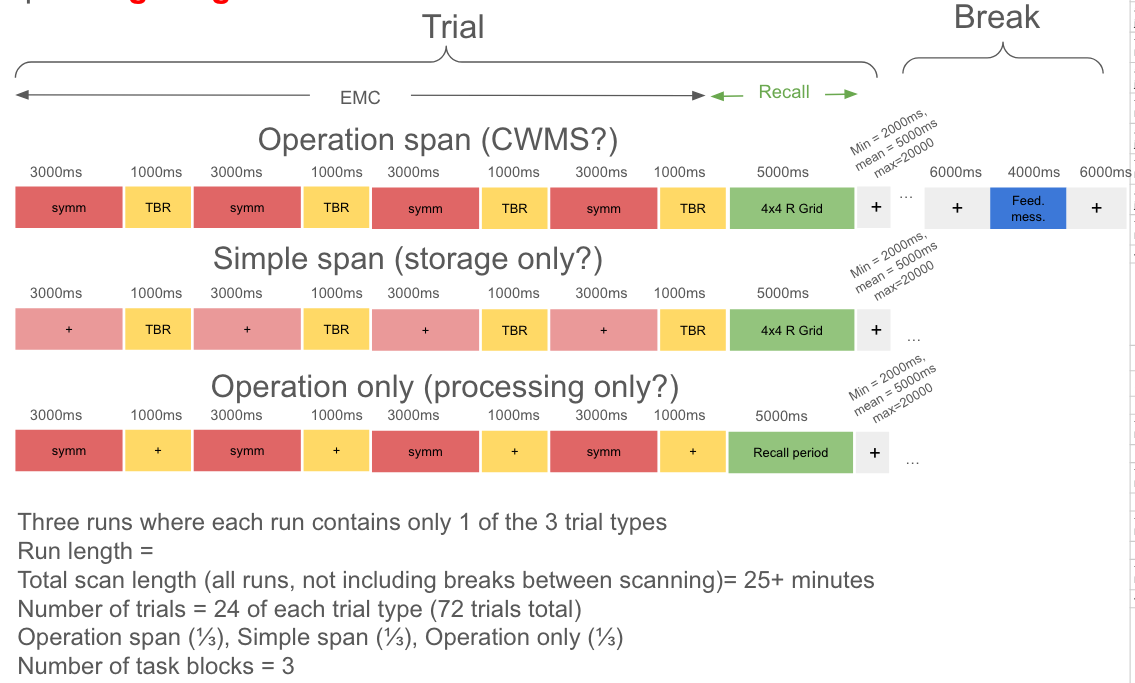

### Important changes  

The task will be split into 3 runs where each run contains only 1 trial type.  Because of this the contrasts of interest are all between-run contrasts:
```
contrasts = {
    'emc_op_span - emc_simple_span': 'emc_op_span - emc_simple_span',
    'emc_op_span - emc_op_only': 'emc_op_span - emc_op_only',
    'recall_op_span - recall_simple_span': 'recall_op_span - recall_simple_span'
}
```
Since they are between-run, I cannot assess efficiency for these contrasts and there isn't much to randomize, other than sampling different ISIs, to impact efficiency.  

The following code for generating the design will be used for all three conditions.  The contrasts of interest will now consist of condition vs baseline for the EMC and recall periods.

In [2]:
def make_span_timings_runs_orig(n_trials, proc_dur, store_dur, recall_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Generates events timings for Span task assuming a single condition is presented for the entire ru
    Assumes a break between blocks of task.  Number of op_span, simple_span, op_only trials will be equal
    for each block of the task 
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      cue(cue_dur) + CTI (3 values for duration) + stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_trials: Total number of trials.  
      cue_dur/cti_dur/stim_dur/blank_dur: Durations of cue/cti/stim/blank.  
                                          All are integers, but cti, which is a vector of 3 values
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
      model_option: One of ['one_component', 'two_components', 'three_components'].  Refers to how cue
                    cti and stimulus are modeled.  Three components models them separately, two models cue+cti together,
                    and one component models cue+cti+stimulus as a single regressor.
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials = n_op_span + n_simple_span + n_op_only
    ntrials_per_block = int(ntrials/nblocks)
    n_op_span_per_block = int( n_op_span / (nblocks))
    n_simple_span_per_block = int(n_simple_span / (nblocks)) 
    n_op_only_per_block = int(n_op_only / (nblocks))
        

    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
#        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['op_span'], n_op_span_per_block),
#                                                        np.repeat(['simple_span'], n_simple_span_per_block),
#                                                        np.repeat(['op_only'], n_op_only_per_block))))
        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['op_span'], n_op_span_per_block),
                                                        np.repeat(['simple_span'], n_simple_span_per_block),
                                                        np.repeat(['op_only'], n_op_only_per_block))))
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            if cur_stim_type == ('op_span') or cur_stim_type == ('simple_span'):
                fragment_durations.extend([isi_vals[isi_count]] + 4*[proc_dur, store_dur] + [recall_dur])
                fragment_labels.extend(['isi_fix'] + [f'first_proc_period_{cur_stim_type}', f'_first_store_period_{cur_stim_type}'] + 3*[f'proc_period_{cur_stim_type}', f'store_period_{cur_stim_type}'] + [f'recall_{cur_stim_type}'])
            if cur_stim_type == 'op_only':
                fragment_durations.extend([isi_vals[isi_count]] + 4*[proc_dur, store_dur])
                fragment_labels.extend(['isi_fix'] + [f'first_proc_period_{cur_stim_type}', f'_first_store_period_{cur_stim_type}'] + 3*[f'proc_period_{cur_stim_type}', f'store_period_{cur_stim_type}'])
            isi_count = isi_count + 1 
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('first_proc|recall|break_message')==True]
    events_data.loc[events_data['trial_type'].str.contains('proc'), 'duration'] = 4*(proc_dur + store_dur)
    events_data.trial_type = events_data.trial_type.str.replace('first_proc_period', 'emc')
    return events_data

In [3]:
def make_span_timings(ntrials, proc_dur, store_dur, recall_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Generates events timings for Span task assuming a single condition is presented for the entire run
    Assumes a break between blocks of task.  
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      EMC period = 4 repeats of [symm(or fix) (proc_dur seconds) + TBR(or fix) (store_dur seconds)] +
      GRID/recall period (5s) +
      fixation (min=2s, max=20s, mean=5s)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_trials: Total number of trials.  
      proc_dur: Processing durations (sym or fixation)
      store_dur: TBR or fixation duration 
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
      model_option: One of ['one_component', 'two_components', 'three_components'].  Refers to how cue
                    cti and stimulus are modeled.  Three components models them separately, two models cue+cti together,
                    and one component models cue+cti+stimulus as a single regressor.
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials_per_block = int(ntrials/nblocks)
    
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        for cur_trial in range(ntrials_per_block):
            fragment_durations.extend([isi_vals[isi_count]] + 4*[proc_dur, store_dur] + [recall_dur])
            fragment_labels.extend(['isi_fix'] + [f'first_proc_period', f'_first_store_period'] + 3*[f'proc_period', f'store_period'] + [f'recall'])
            isi_count = isi_count + 1 
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('first_proc|recall|break_message')==True]
    events_data.loc[events_data['trial_type'].str.contains('proc'), 'duration'] = 4*(proc_dur + store_dur)
    events_data.trial_type = events_data.trial_type.str.replace('first_proc_period', 'emc')
    return events_data

In [4]:
events_inputs = {
    'ntrials': 24,
    'proc_dur' : 3, 
    'store_dur': 1, 
    'recall_dur': 5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': .33,
    'isi_truncation': 20,
    'isi_shift': 2
}

#locals().update(events_inputs)

tr = 1.49
total_time =  60*12

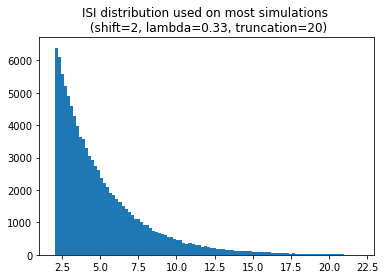

theoretical mean
5.003058607109558
quartiles
[ 2.     2.868  4.097  6.187 21.966]


In [5]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(events_inputs['isi_exp_lam'], events_inputs['isi_truncation'], 
                                                                 events_inputs['isi_shift'], nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.title(f"ISI distribution used on most simulations \n (shift={events_inputs['isi_shift']}, lambda={events_inputs['isi_exp_lam']}, truncation={events_inputs['isi_truncation']})")
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [6]:
#  This doesn't apply for this task.

trials_psych_assess_map = {'proc_period': '1'}

unpermuted_trials = np.repeat('1', events_inputs['ntrials'])
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info.loc[:50, :])

    run_length  1_run_counts
0          1.0           0.0
1          2.0           0.0
2          3.0           0.0
3          4.0           0.0
4          5.0           0.0
5          6.0           0.0
6          7.0           0.0
7          8.0           0.0
8          9.0           0.0
9         10.0           0.0
10        11.0           0.0
11        12.0           0.0
12        13.0           0.0
13        14.0           0.0
14        15.0           0.0
15        16.0           0.0
16        17.0           0.0
17        18.0           0.0
18        19.0           0.0
19        20.0           0.0
20        21.0           0.0
21        22.0           0.0
22        23.0           0.0
23        24.0           3.0


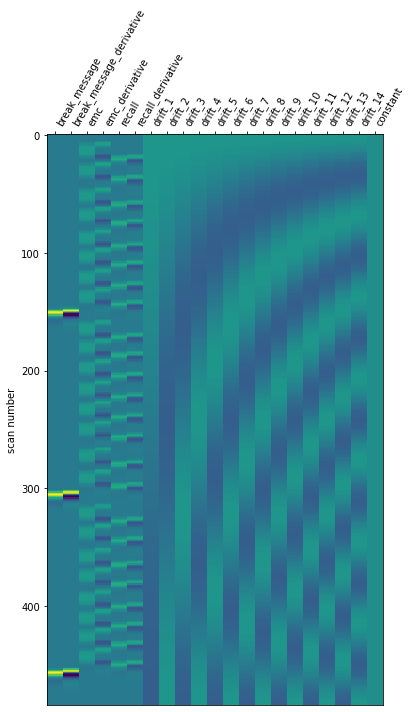

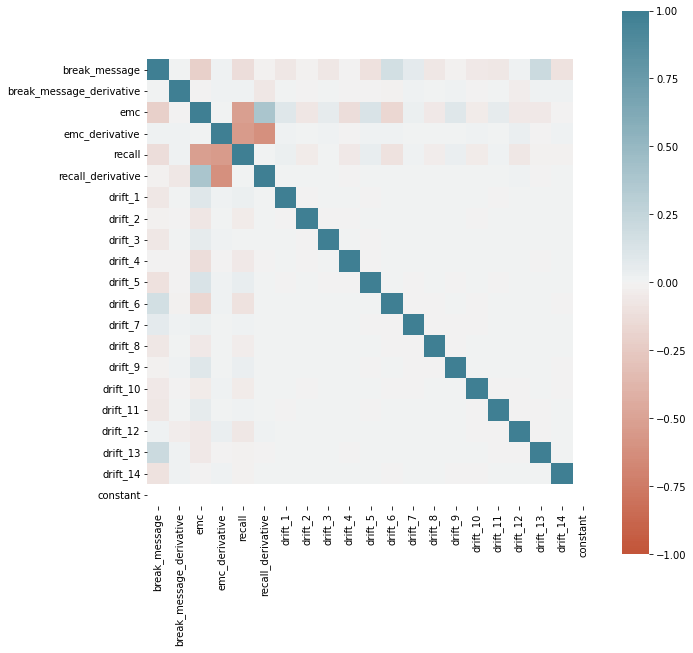

{'recall vs baseline': 12.045660564150271, 'emc vs baseline': 40.01702929639439}
{'recall vs baseline': 3.6801820851609786, 'emc vs baseline': 2.8464557821805316}


In [7]:
#contrasts = {
#    'emc_op_span - emc_simple_span': 'emc_op_span - emc_simple_span',
#    'emc_op_span - emc_op_only': 'emc_op_span - emc_op_only'
#}

contrasts = {
    'recall vs baseline': 'recall',
    'emc vs baseline': 'emc'
}

events_ts = make_span_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts, deriv=True)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()
print(eff)
print(vif)

In [8]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_span_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, deriv=False, est_psych=False)


In [9]:
pd.set_option('display.width', 1000)
summary_names = [f'eff_{name}' for name in contrasts.keys()] + \
                [f'vif_{name}' for name in contrasts.keys()] + \
                ['scan_length']

eff_vif_summaries_span = {}
eff_vif_summaries_span['setting: original']= np.round(output_setting1[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_span.items():
    print(f'Results for {key}')
    print(val)

Results for setting: original
      eff_recall vs baseline  eff_emc vs baseline  vif_recall vs baseline  vif_emc vs baseline  scan_length
0.05                   20.19                43.78                    1.63                 1.73       663.83
0.50                   23.56                54.70                    1.89                 2.04       685.53
0.95                   27.37                68.11                    2.20                 2.40       711.37
